In [1]:
%matplotlib inline
import time 
from qutip import mesolve, steadystate
import numpy as np
import optical as EM
import phonons as RC
import leads as FL
from utils import *
from photocell_setup import *
import matplotlib.pyplot as plt
#from importlib import reload
from style import *

utils imported


In [2]:
def short_current(v,c):
    # assumes that V=0 at element 0
    return c[0]

def estimate_Voc(v, c):
    # voltage where current goes to zero
    return v[np.argmin(np.abs(c))]

def power_values(v, c):
    return np.array(v)*np.array(c)

def max_power(v, c):
    # can make this more sophisticated at a later date
    return np.max(power_values(v, c))

def theoretical_max_power(v,c):
    return short_current(v,c)*estimate_Voc(v, c)

def fill_factor(v, c):
    return max_power(v, c)/theoretical_max_power(v,c)

def fill_factor_from_dict(_data_dict):
    return fill_factor(_data_dict['bias_voltages'], _data_dict['current'])

def plot_power(_data_dict):
    current = _data_dict['current']
    
    voltage = _data_dict['bias_voltages']*ev_to_inv_cm
    power = power_values(voltage, current)
    plt.plot(voltage, power)
    plt.axvline(estimate_Voc(voltage, current))
    plt.axhline(max_power(power))
    
def get_photovoltaic_summary(data_dict):
    v, c = data_dict['bias_voltages'], data_dict['current']
    return {"fill-factor": fill_factor_from_dict(data_dict), 
         "V_OC" : estimate_Voc(v, c),
         "I_SC" : short_current(v, c),
         "P_max": max_power(data_dict['bias_voltages'], data_dict['current']),
         "P_theoretical_max": theoretical_max_power(v,c)
        }

In [3]:
def populations_and_current_vs_voltage(PARAMS, x_scale=1.8):
    ti = time.time()
    if PARAMS['T_L']<100:
        number_of_voltages = 180
    else:
        number_of_voltages = 100
    bias_voltages = np. linspace(0, PARAMS['omega_exciton']*x_scale, number_of_voltages)
    current = []
    conduction_population = []
    valence_population = []
    ground_population = []
    hole_population = []
    electron_population = []
    exciton_population = []
    ops = make_expectation_operators(PARAMS)
    for i, bv in enumerate(bias_voltages):
        PARAMS.update({'mu_R': PARAMS['mu']+bv/2, 'mu_L': PARAMS['mu']-bv/2})
        #if i in [10, 90]:
        #    print_PARAMS(PARAMS)
        L_Lindblad_dict = build_L(PARAMS, silent=True)
        #ops = make_expectation_operators(PARAMS)
        n_c = tensor(d_e.dag()*d_e, qeye(PARAMS['N']))
        n_v = tensor(d_h.dag()*d_h, qeye(PARAMS['N']))
        ss = steadystate(L_Lindblad_dict['H_S'], [L_Lindblad_dict['L_lindblad']])
        current.append(current_from_ss(ss, L_Lindblad_dict['L_R_lindblad'], n_c))
        conduction_population.append((n_c*ss).tr())
        valence_population.append((n_v*ss).tr())
        ground_population.append((ops['vac']*ss).tr())
        hole_population.append((ops['hole']*ss).tr())
        electron_population.append((ops['electron']*ss).tr())
        exciton_population.append((ops['exciton']*ss).tr())
    bias_voltages/=ev_to_inv_cm
    data_dict = {'bias_voltages':bias_voltages, 
                 'current': current,
                 'conduction_population' : conduction_population, 
                 'valence_population' : valence_population,
                 'ground_population': ground_population,
                 'hole_population' : hole_population,
                 'electron_population' : electron_population,
                 'exciton_population' : exciton_population,
                'PARAMS': PARAMS}
    print("C-V data calculated in {:0.1f} seconds".format(time.time() - ti))
    return data_dict

In [142]:
def plot_voltage_current(data_dict, label=''):
    # if 
    _PARAMS = data_dict['PARAMS']
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10), sharex=True)
    
    X = data_dict['bias_voltages']
    red_mu_R, red_mu_L = _PARAMS['omega_c'], 2*_PARAMS['mu']-_PARAMS['omega_c']
    blue_mu_R  = 2*_PARAMS['mu']+(_PARAMS['omega_v']-_PARAMS['binding_energy'])
    blue_mu_L = -(_PARAMS['omega_v']-_PARAMS['binding_energy'])
    
    
    if abs(_PARAMS['binding_energy'])>0:
        yellow_mu_R = _PARAMS['omega_c']-_PARAMS['binding_energy']
        yellow_mu_L = 2*_PARAMS['mu']-(_PARAMS['omega_c']-_PARAMS['binding_energy'])
        yellow_mu_R/= ev_to_inv_cm
        yellow_mu_L/= ev_to_inv_cm
        ax2.axvline(yellow_mu_R - yellow_mu_L, linestyle='dotted', color=colors[5], linewidth=2.2)
        if _PARAMS['mu']<(_PARAMS['bandgap']/2):
            red_mu_R = 2*_PARAMS['mu']+_PARAMS['omega_v']
            red_mu_L = 2*_PARAMS['mu']-(red_mu_R)
    red_mu_R /= ev_to_inv_cm
    red_mu_L /= ev_to_inv_cm
    blue_mu_R/= ev_to_inv_cm
    blue_mu_L/= ev_to_inv_cm
    
    
    
    ax2.axvline(blue_mu_R-blue_mu_L, linestyle='dotted', color=colors[1], linewidth=2)
    ax2.axvline(red_mu_R-red_mu_L, linestyle='dotted', color=colors[0], linewidth=2)
    ax1.plot(X, np.array(data_dict['conduction_population']).real, label=r'$n_c$')
    ax1.plot(X, np.array(data_dict['valence_population']).real, label=r'$n_v$')
    ax2.set_xlabel('Bias voltage (eV)')
    ax1.set_ylabel('Population')
    ax2.set_ylabel('Current')
    #ax1.plot(X, np.array(data_dict['ground_population']).real, label=r'v')
    #ax1.plot(X, np.array(data_dict['hole_population']).real, label=r'h')
    #ax1.plot(X, np.array(data_dict['electron_population']).real, label=r'e')
    #ax1.plot(X, np.array(data_dict['exciton_population']).real, label=r'exc')
    ax1.set_xlim(0,X[-1])
    ax1.legend()
    plt.subplots_adjust(left=0.18, bottom=0.065, right=0.97, top=0.98, wspace=0.24, hspace=0.015)
    q = 1.602176634e-19 # coulomb
    current = np.array(data_dict['current']).real # in electrons per second?
    ax2.plot(X, current)
    plt_title = "PLOTS/C-V-{}.pdf".format(label)
    plt.savefig(plt_title)
    print("saved at "+plt_title)

In [118]:
data_dict_no_BE_1['PARAMS']['omega_exciton'], data_dict_100_1['PARAMS']['omega_exciton']

(12904.799999999997, 12098.249999999998)

In [148]:
data_dict_100_1['PARAMS']['omega_exciton']-data_dict_100_1['PARAMS']['omega_v']

11291.699999999999

# No binding energy

saved at PLOTS/C-V-center-0meV.pdf
saved at PLOTS/C-V-above-0meV.pdf
saved at PLOTS/C-V-below-0meV.pdf


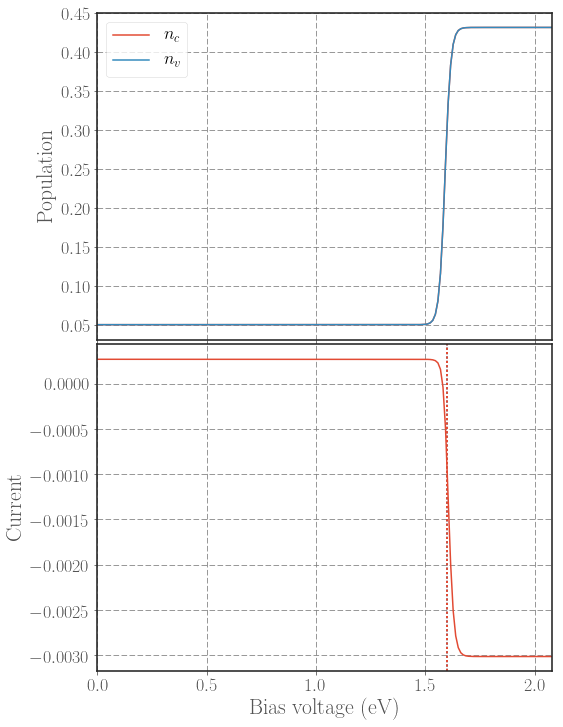

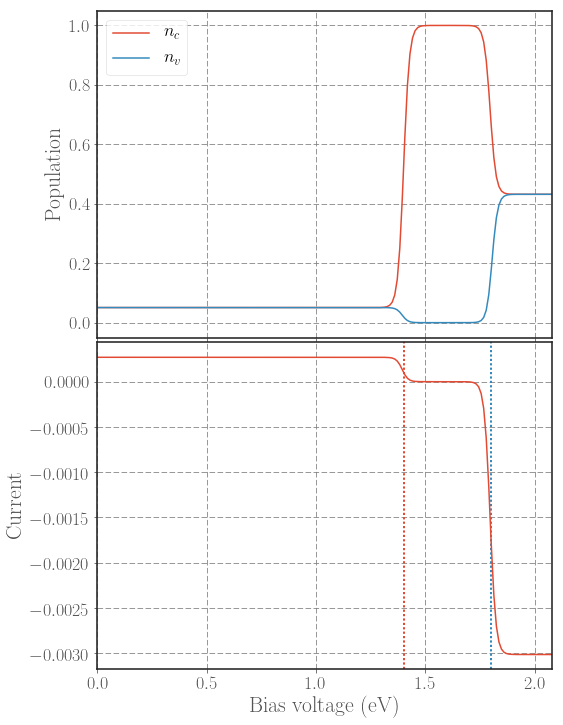

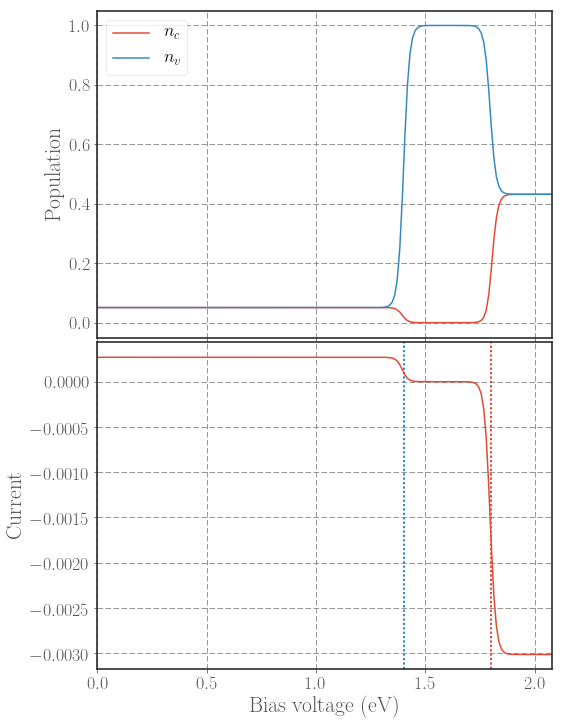

In [132]:
#PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.0, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
#                      bias_voltage=0, N=2, silent=False, T_C=77.)

#data_dict_no_BE_1 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_no_BE_1, label='center-0meV')

#PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.0, radiative_lifetime=1, alpha_ph=0, mu=800e-3,
#                      bias_voltage=0, N=2, silent=False, T_C=77.)

#data_dict_no_BE_2 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_no_BE_2, label='above-0meV')

#PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.0, radiative_lifetime=1, alpha_ph=0, mu=600e-3,
#                      bias_voltage=0, N=2, silent=False, T_C=77.)

#data_dict_no_BE_3 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_no_BE_3, label='below-0meV')

# Small binding energy

saved at PLOTS/C-V-center-100meV.pdf
saved at PLOTS/C-V-above-100meV.pdf
saved at PLOTS/C-V-below-100meV.pdf


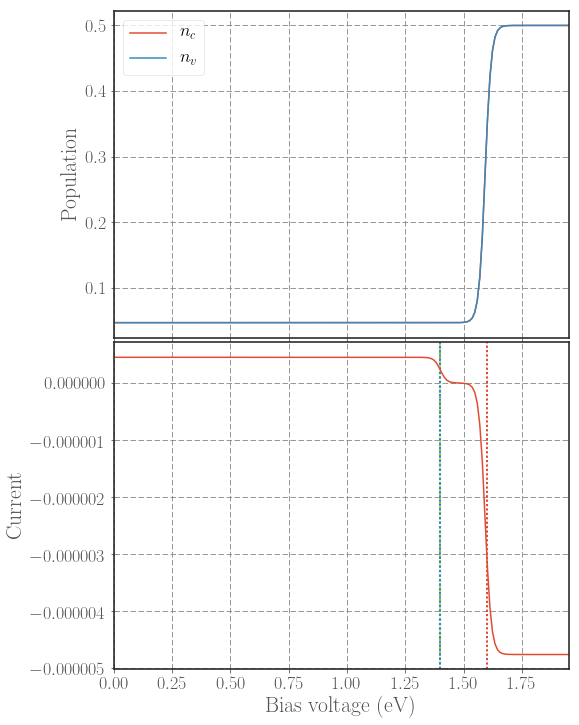

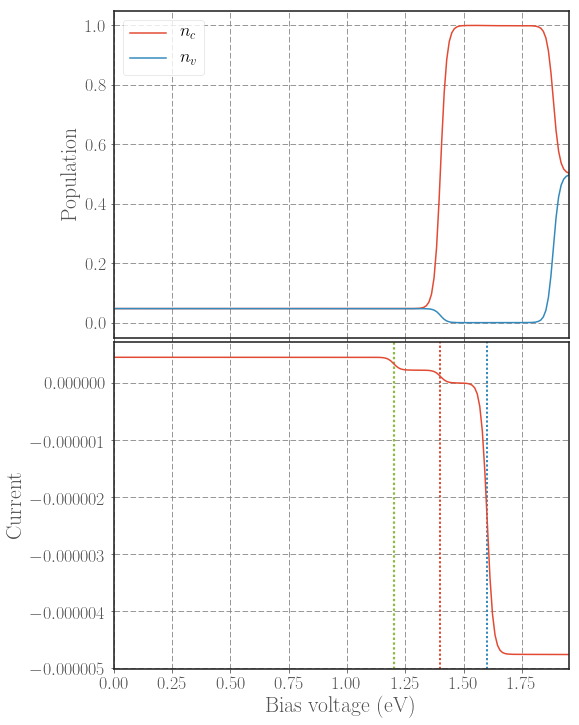

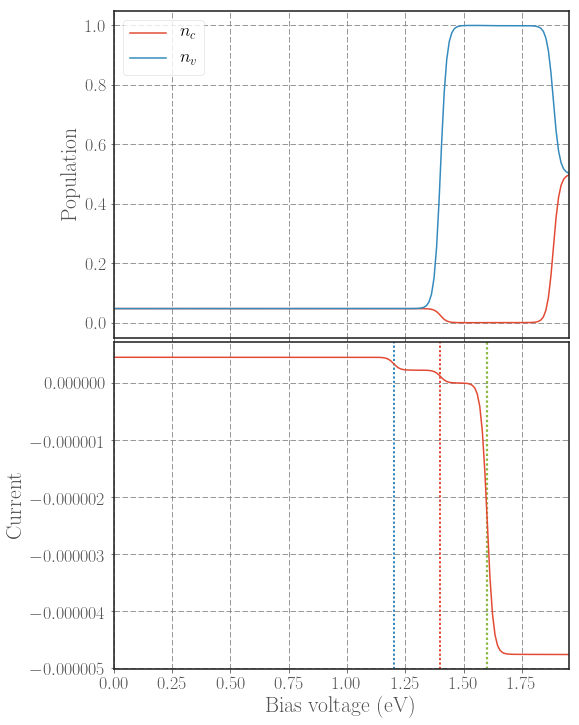

In [143]:
#PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.1, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
#                      bias_voltage=0, N=2, silent=False, T_C=77.)

#data_dict_100_1 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_100_1, label='center-100meV')

#PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.1, radiative_lifetime=1, alpha_ph=0, mu=800e-3,
#                      bias_voltage=0, N=2, silent=False, T_C=77.)

#data_dict_100_2 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_100_2, label='above-100meV')

#PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.1, radiative_lifetime=1, alpha_ph=0, mu=600e-3,
#                      bias_voltage=0, N=2, silent=False, T_C=77.)

#data_dict_100_3 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_100_3, label='below-100meV')

# Medium binding energy

Phonon occupation: 0.00. Phonon thermal energy is 53.51. Phonon SD peak is 0.00. V=0.0. N=2.
C-V data calculated in 39.8 seconds
saved at PLOTS/C-V-center-200meV.pdf
Phonon occupation: 0.00. Phonon thermal energy is 53.51. Phonon SD peak is 0.00. V=0.0. N=2.
C-V data calculated in 36.2 seconds
saved at PLOTS/C-V-above-200meV.pdf
Phonon occupation: 0.00. Phonon thermal energy is 53.51. Phonon SD peak is 0.00. V=0.0. N=2.
C-V data calculated in 36.9 seconds
saved at PLOTS/C-V-below-200meV.pdf


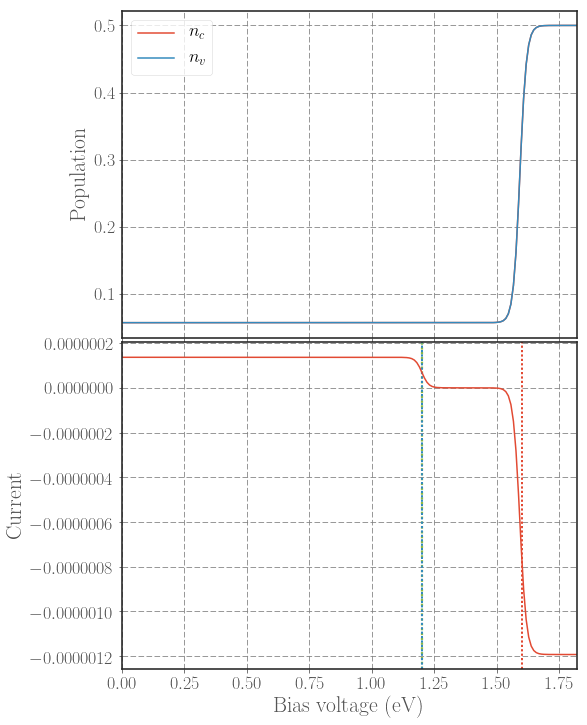

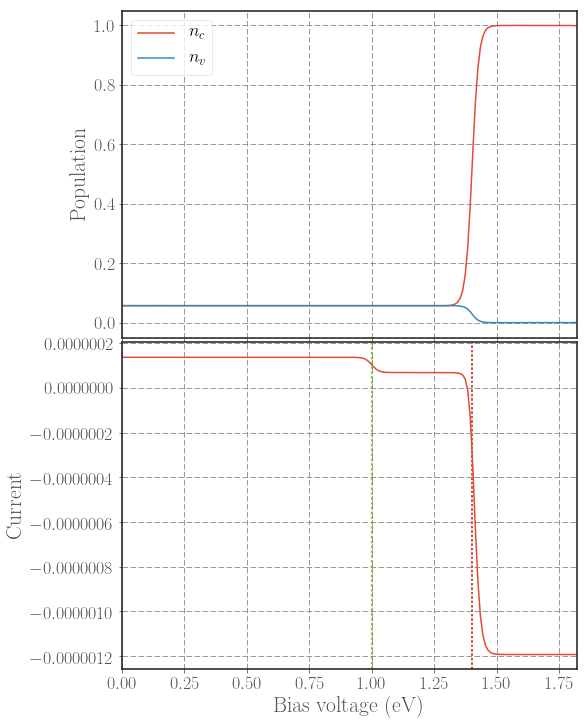

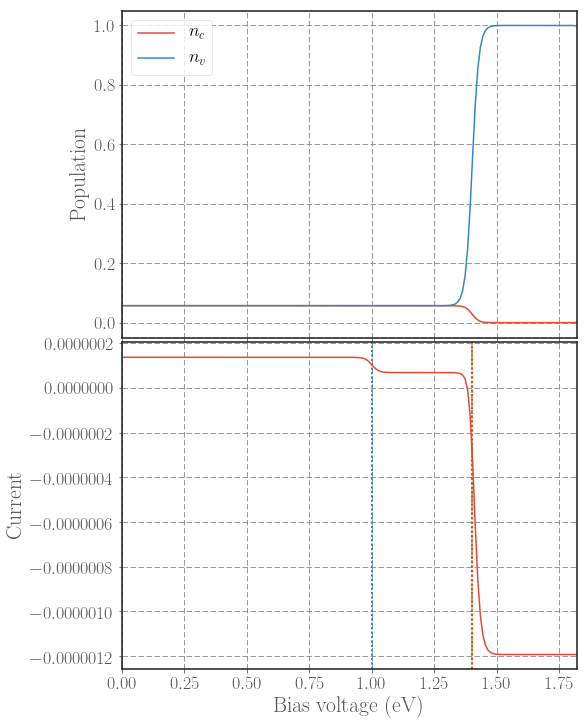

In [149]:
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.2, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

data_dict_200_1 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_200_1, label='center-200meV')

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.2, radiative_lifetime=1, alpha_ph=0, mu=800e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

data_dict_200_2 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_200_2, label='above-200meV')

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.2, radiative_lifetime=1, alpha_ph=0, mu=600e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

data_dict_200_3 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_200_3, label='below-200meV')

Phonon occupation: 0.00. Phonon thermal energy is 53.51. Phonon SD peak is 0.00. V=0.0. N=2.
C-V data calculated in 34.8 seconds
saved at PLOTS/C-V-center-300meV.pdf
Phonon occupation: 0.00. Phonon thermal energy is 53.51. Phonon SD peak is 0.00. V=0.0. N=2.
C-V data calculated in 34.0 seconds
saved at PLOTS/C-V-above-300meV.pdf
Phonon occupation: 0.00. Phonon thermal energy is 53.51. Phonon SD peak is 0.00. V=0.0. N=2.
C-V data calculated in 34.1 seconds
saved at PLOTS/C-V-below-300meV.pdf


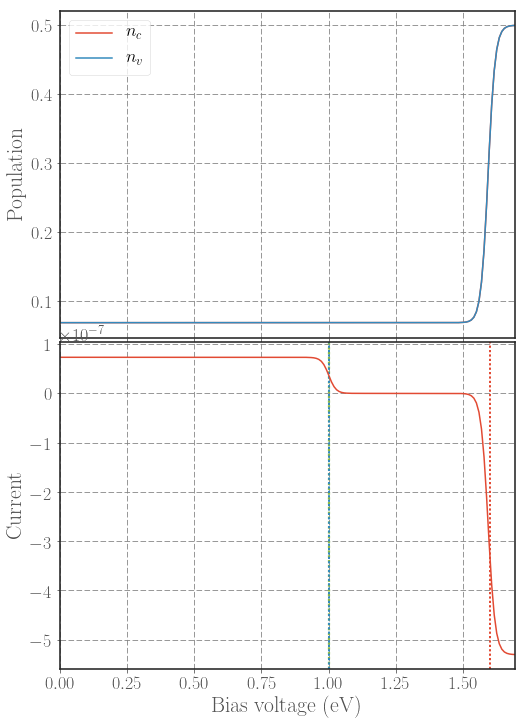

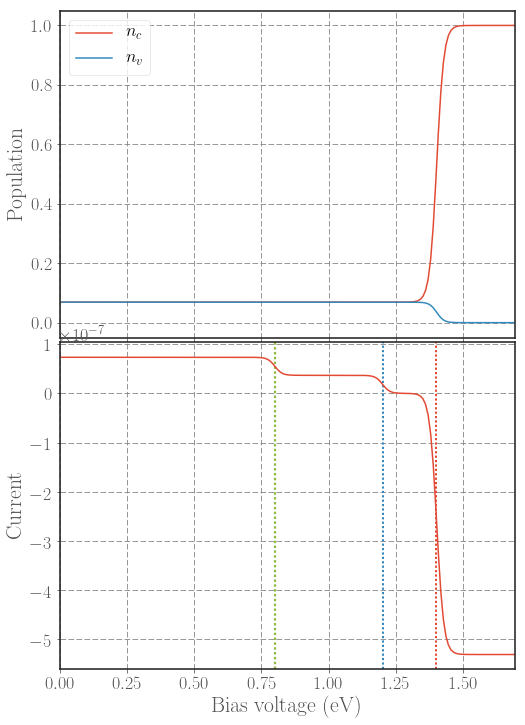

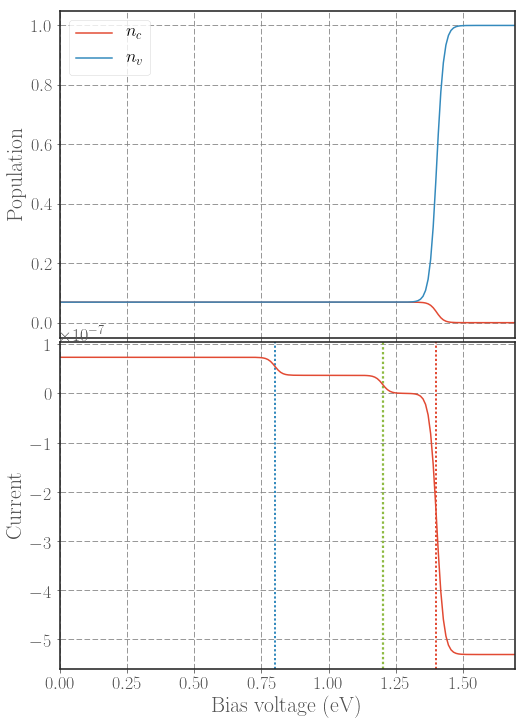

In [150]:
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.3, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

data_dict_300_1 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_300_1, label='center-300meV')

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.3, radiative_lifetime=1, alpha_ph=0, mu=800e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

data_dict_300_2 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_300_2, label='above-300meV')

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.3, radiative_lifetime=1, alpha_ph=0, mu=600e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

data_dict_300_3 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_300_3, label='below-300meV')

## Analytical results

In [6]:
def CS_analytical_current(PARAMS):
    Gamma_Ldown, Gamma_Lup, Gamma_Rdown, Gamma_Rup = FL.leads_rates(PARAMS)
    Gamma_downEM, Gamma_upEM = EM.EM_rates(PARAMS)
    Gamma_downEM*=2
    Gamma_upEM*=2
    
    numer = 2*(Gamma_Ldown+Gamma_Lup+Gamma_Rdown+Gamma_Rup)
    numer*=(Gamma_downEM*Gamma_Ldown*Gamma_Rup-Gamma_Lup*Gamma_Rdown*Gamma_upEM)
    denom = (Gamma_Ldown+Gamma_Lup)*(Gamma_Rdown+Gamma_Rup)*(Gamma_Ldown+Gamma_Lup+Gamma_Rdown+Gamma_Rup)
    denom += Gamma_downEM*(Gamma_Ldown**2+(Gamma_Rup+Gamma_Lup)*(Gamma_Rdown+Gamma_Rup)+Gamma_Ldown*(Gamma_Lup+Gamma_Rdown+Gamma_Rup))
    denom += (Gamma_Lup**2+Gamma_Lup*(Gamma_Rdown+Gamma_Rup)+Gamma_Rdown*(Gamma_Rdown+Gamma_Rup)+Gamma_Ldown*(Gamma_Lup+Gamma_Rdown+Gamma_Rup))*Gamma_upEM
    return -numer/denom

def rate_analytical_current():
    numer = Gamma_downalpha*Gamma_downbeta*Gamma_downI*Gamma_upEM
    numer-= Gamma_downEM*Gamma_upalpha*Gamma_upbeta*Gamma_upI
    denom = (Gamma_downI+Gamma_upalpha)*(Gamma_downEM*Gamma_upbeta + Gamma_downbeta*(Gamma_downEM+Gamma_upEM))
    denom = Gamma_downEM*(Gamma_upalpha+Gamma_upbeta)
    #nenom = Gamma_downalpha*Gamma_downbeta*Gamma_downI+Gamma_upEM+(Gamma_downI+Gamma_upI) (\Gamma _{\text{upC$\beta $}}+\Gamma _{\text{upEM}}\right)\right)+\left(\Gamma _{\text{downI}}+\Gamma _{\text{upC$\alpha $}}\right) \left(\Gamma _{\text{downC$\beta $}} \left(\Gamma _{\text{downEM}}+\Gamma _{\text{upEM}}\right)+\Gamma _{\text{downEM}} \Gamma _{\text{upC$\beta $}}\right)+\Gamma _{\text{upI}} \left(\Gamma _{\text{downEM}} \left(\Gamma _{\text{upC$\alpha $}}+\Gamma _{\text{upC$\beta $}}\right)+\Gamma _{\text{upC$\alpha $}} \left(\Gamma _{\text{upC$\beta $}}+\Gamma _{\text{upEM}}\right)\right)}

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.0, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=2, N=2, silent=False, T_C=77.)
#Gamma_Ldown, Gamma_Lup, Gamma_Rdown, Gamma_Rup, Gamma_downEM, Gamma_upEM  = get_rates(PARAMS)
print(print_PARAMS(PARAMS))
print (CS_analytical_current(PARAMS))
print(get_photovoltaic_summary(data_dict_no_BE))

Phonon occupation: 0.00. Phonon thermal energy is 53.51. Phonon SD peak is 0.00. V=32262.0. N=2.
bandgap : 11291.7
mu_R : 21776.85
mu_L : -10485.15
delta_R : 24.1965
mu : 5645.85
Omega_ph : 403.275
T_ph : 77.0
binding_energy : 0.0
deformation_ratio : 0.5
radiative_lifetime : 1
leads_lifetime : 1
omega_exciton : 12904.8
Gamma_EM : 0.005309
Omega_R : 12098.25
J : <function J_minimal at 0x7f1de203ecf8>
omega_v : 806.55
T_EM : 5800
alpha_ph : 0.0
Omega_L : -806.55
omega_c : 12098.25
N : 2
Gamma_L : 0.005309
T_L : 77.0
sys_dim : 4
Gamma_ph : 80.655
delta_L : 24.1965
T_R : 77.0
Gamma_R : 0.005309
None
(-0.00301617496328+0j)
{'P_theoretical_max': 0.00042642996630739812, 'I_SC': 0.0002698351384651593, 'P_max': 0.00040695336368906377, 'fill-factor': 0.95432637441737767, 'V_OC': 1.5803351955307261}
